In [1]:
import sys
import os
import shap
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, median_absolute_error, max_error
from xgboost import XGBRegressor
from statsmodels.stats.stattools import durbin_watson

# Import utilities from a different path
sys.path.append(os.path.abspath('../Calculations'))
from utilities import pre_process_data, map_dataset 
from travel_insurance_premium import generate_test_data, important_features 

In [2]:
shap.initjs()

In [3]:
TARGET_COLUMN = 'Premium'

In [4]:
# Train XGBoost Model with train sets
def train_xgboost_model(X_train, y_train):
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model

In [5]:
def perform_shap_analysis(model, X_test):
    explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    shap_feature_importance = dict(zip(X_test.columns, np.mean(np.abs(shap_values), axis=0)))
    return shap_values, shap_feature_importance, explainer

In [6]:
# Custom metric functions
def smape(y_true, y_pred):
    """Calculate Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def quantile_loss(y_true, y_pred, quantile=0.5):
    """Calculate Quantile Loss"""
    residual = y_true - y_pred
    return np.mean(np.maximum(quantile * residual, (quantile - 1) * residual))

In [7]:
def evaluate_model(model, X_test, y_test, sample_size):
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    r2_score = model.score(X_test, y_test)
    mse_score = mean_squared_error(y_test, y_pred)
    mae_score = mean_absolute_error(y_test, y_pred)
    rmse_score = np.sqrt(mse_score)
    accuracy_score = explained_variance_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)
    rae = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test - np.mean(y_test)))
    smape_value = smape(y_test, y_pred)
    bias = np.mean(y_pred - y_test)
    interval = 1.96 * np.std(y_pred)
    lower_bound = y_pred - interval
    upper_bound = y_pred + interval
    picp = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
    cv = np.std(y_pred) / np.mean(y_pred)
    quantile_loss_value = quantile_loss(y_test, y_pred, quantile=0.5)
    residuals = y_test - y_pred
    durbin_watson_stat = durbin_watson(residuals) 
    return {
            'Sample Size': sample_size,
            'R²': r2_score,
            'MAE': mae_score,
            'RMSE': rmse_score,
            'Accuracy': accuracy_score,
            'MedAE': medae,
            'Max Error': max_err,
            'RAE': rae,
            'sMAPE': smape_value,
            'Bias': bias,
            'PICP': picp,
            'CV': cv,
            'Quantile Loss': quantile_loss_value,
            'Durbin-Watson': durbin_watson_stat,
        }
    

## Generate a test case

In [8]:
travel_test_data = generate_test_data(50000)

Generating data:   0%|          | 0/50000 [00:00<?, ?it/s]

2.  Preprocess data and train/test split

In [9]:
X_processed, y, mappings = pre_process_data(travel_test_data, target_column=TARGET_COLUMN)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [10]:
# Train XGBoost model
xgboost_model = train_xgboost_model(X_train, y_train)

In [11]:
evaluation_metrics = evaluate_model(xgboost_model, X_test, y_test,travel_test_data.shape[0])

In [12]:
evaluation_metrics

{'Sample Size': 50000,
 'R²': 0.9078588156727426,
 'MAE': 86.40717294658526,
 'RMSE': 124.40501929729515,
 'Accuracy': 0.9078707532120263,
 'MedAE': 59.40819763183595,
 'Max Error': 1014.9231738281251,
 'RAE': 0.28102482934669776,
 'sMAPE': 21.9950056263753,
 'Bias': 1.4160168286527697,
 'PICP': 0.9995,
 'CV': 0.9227168,
 'Quantile Loss': 43.20358647329263,
 'Durbin-Watson': 1.9903980679010205}

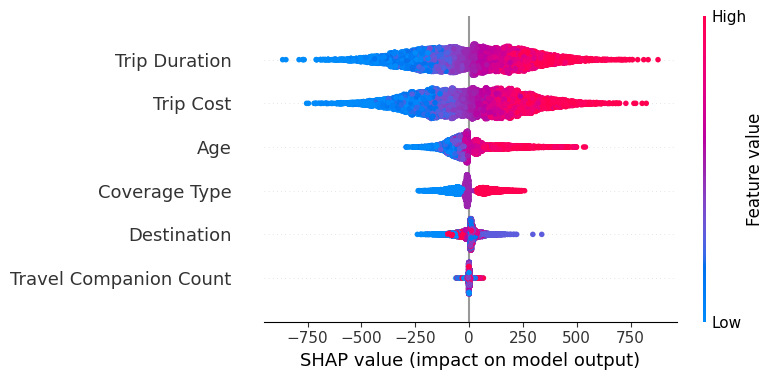

In [13]:
# Perform SHAP analysis
shap_values, shap_feature_importance,xgb_explainer = perform_shap_analysis(xgboost_model, X_test)
# Display the summary plot
shap.summary_plot(shap_values, X_test)

In [14]:
shap_accuracy_predictor = joblib.load('../Experiment 2 - SHAP Precision ML/saved_models/stacking_model.joblib')


In [15]:
eval_parameters_df = pd.DataFrame([evaluation_metrics])
eval_parameters_df = eval_parameters_df.drop(['RMSE','MAE','Quantile Loss','Accuracy','CV','Durbin-Watson'], axis=1)

In [16]:
shap_matching_percentage = shap_accuracy_predictor.predict(eval_parameters_df)

In [17]:

# Print results
print("XGBoost Model Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTop 5 SHAP Feature Importance for XGBoost:")
for feature, importance in sorted(shap_feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{feature}: {importance:.4f}")

print(f"\nSHAP Feature Matching Percentage with Predictor: {shap_matching_percentage[0]:.2f}%")

XGBoost Model Evaluation Metrics:
Sample Size: 50000.0000
R²: 0.9079
MAE: 86.4072
RMSE: 124.4050
Accuracy: 0.9079
MedAE: 59.4082
Max Error: 1014.9232
RAE: 0.2810
sMAPE: 21.9950
Bias: 1.4160
PICP: 0.9995
CV: 0.9227
Quantile Loss: 43.2036
Durbin-Watson: 1.9904

Top 5 SHAP Feature Importance for XGBoost:
Trip Duration: 207.8340
Trip Cost: 195.1313
Age: 83.8250
Coverage Type: 62.9088
Destination: 39.6841

SHAP Feature Matching Percentage with Predictor: 97.81%


In [18]:
# Function to generate the AI report prompt
def generate_report_prompt():
    # Generating the prompt text
    prompt = (
        "As an AI language model specializing in insurance and regulatory compliance, your task is to create a "
        "comprehensive report for a regulatory agency about how an insurance premium is calculated based on the "
        "following XGBoost model evaluation metrics and SHAP feature importance data:\n\n"
        "XGBoost Model Evaluation Metrics:\n"
    )

    # Append evaluation metrics to the prompt
    for metric, value in evaluation_metrics.items():
        prompt += f"- {metric}: {value:.4f}\n"

    # Append SHAP feature importance to the prompt
    prompt += "\nTop 5 SHAP Features by Importance:\n"
    for feature, importance in shap_feature_importance.items():
        prompt += f"{feature}: {importance:.4f}\n"

    # Add SHAP feature matching percentage
    prompt += f"\nSHAP Feature Matching Percentage with Predictor: {shap_matching_percentage[0]:.2f}%\n"

    # Append detailed report requirements
    prompt += (
        "\nBased on this information, please provide a detailed report that includes:\n"
        "1. An executive summary of the premium calculation model's performance.\n"
        "2. An explanation of how each of the top 5 features influences the premium calculation, "
        "including any potential biases or fairness considerations.\n"
        "3. An analysis of the model's accuracy and reliability, referencing the provided metrics.\n"
        "4. A comparison between this model and the Predictor model, based on the SHAP feature matching percentage.\n"
        "5. Recommendations for potential improvements or areas that may require further investigation "
        "from a regulatory perspective.\n"
        "6. Any ethical considerations or potential risks associated with using this model for premium calculations.\n\n"
        "Please ensure the report is written in a clear, concise manner suitable for a regulatory audience, "
        "with appropriate technical depth and explanations of any industry-specific terms or concepts used."
    )

    return prompt


# Print the generated prompt
print(generate_report_prompt())


As an AI language model specializing in insurance and regulatory compliance, your task is to create a comprehensive report for a regulatory agency about how an insurance premium is calculated based on the following XGBoost model evaluation metrics and SHAP feature importance data:

XGBoost Model Evaluation Metrics:
- Sample Size: 50000.0000
- R²: 0.9079
- MAE: 86.4072
- RMSE: 124.4050
- Accuracy: 0.9079
- MedAE: 59.4082
- Max Error: 1014.9232
- RAE: 0.2810
- sMAPE: 21.9950
- Bias: 1.4160
- PICP: 0.9995
- CV: 0.9227
- Quantile Loss: 43.2036
- Durbin-Watson: 1.9904

Top 5 SHAP Features by Importance:
Trip Cost: 195.1313
Trip Duration: 207.8340
Age: 83.8250
Travel Companion Count: 2.9447
Destination: 39.6841
Coverage Type: 62.9088

SHAP Feature Matching Percentage with Predictor: 97.81%

Based on this information, please provide a detailed report that includes:
1. An executive summary of the premium calculation model's performance.
2. An explanation of how each of the top 5 features influ

In [19]:
single_submission = travel_test_data = generate_test_data(1)

Generating data:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
X, y = map_dataset(single_submission, mappings,TARGET_COLUMN)

In [21]:
X

,Trip Cost,Trip Duration,Age,Travel Companion Count,Destination,Coverage Type
0,2617,13,70,1,3,0


In [22]:
predicted_premium = xgboost_model.predict(X)
predicted_premium = predicted_premium[0]

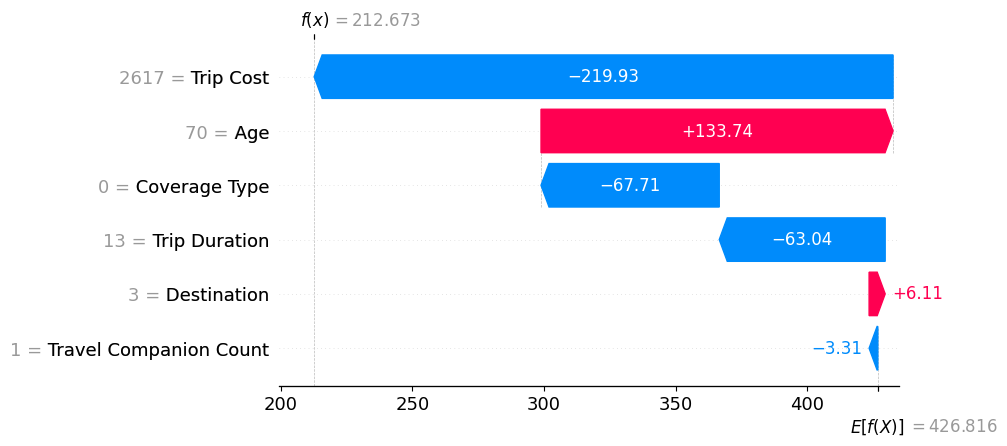

In [23]:
shap_values_single =xgb_explainer(X)

shap.waterfall_plot(shap_values_single[0]) 

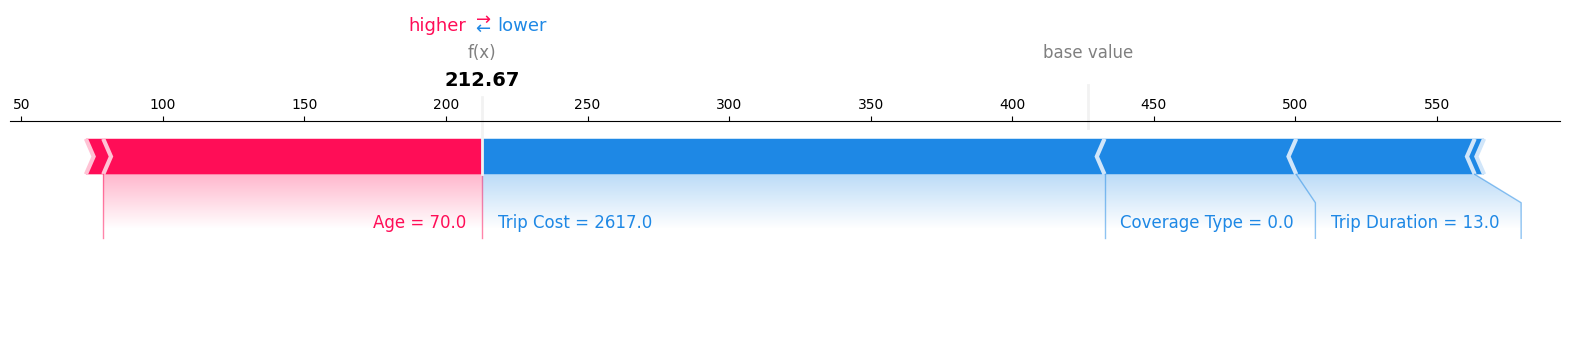

In [24]:
shap.force_plot(xgb_explainer.expected_value, shap_values_single[0].values, X, matplotlib=True)


In [27]:
single_instance_premium

NameError: name 'single_instance_premium' is not defined

In [28]:
def generate_ai_report_prompt(X, single_instance_premium, prediction, shap_values, shap_match_percentage):
    # Calculate premium difference
    premium_difference = single_instance_premium[0] - prediction
    
    # Create a formatted string with all the information
    risk_factors_str = "\n".join([f"    {feature}: {value}" for feature, value in X.iloc[0].items()])
    shap_values_str = "\n".join([f"    {feature}: {value:.4f}" for feature, value in zip(X.columns, shap_values[0])])
    
    prompt = f"""As an AI specializing in insurance analysis, your task is to create a comprehensive report for a customer based on their insurance quotation. Use the following data to generate your report:
    Risk Factors:
    {risk_factors_str}
    
    Actual Premium: ${single_instance_premium[0]:.2f}
    Predicted Premium: ${prediction:.2f}
    Premium Difference: ${premium_difference:.2f}


    SHAP Values:
    {shap_values_str}

    SHAP Match Percentage: {shap_match_percentage[0]:.2f}%

    Please create a detailed report that includes:
    1. An introduction explaining the purpose of the report.
    2. A summary of the customer's risk factors and how they influence the premium.
    3. A comparison between the actual premium and the predicted premium, including an explanation of the difference.
    4. An analysis of the SHAP values, explaining how each factor contributes to the premium calculation.
    5. An explanation of the SHAP match percentage and its significance.
    6. Recommendations for the customer based on this analysis (e.g., ways to potentially lower their premium).
    7. A conclusion summarizing the key points of the report.

    Please ensure the report is written in a clear, professional tone that is easily understandable by someone without a background in insurance or data science. Use analogies or examples where appropriate to illustrate complex concepts.

    The report should be structured with appropriate headings and subheadings, and should be approximately 800-1000 words long."""
    return prompt

# Generate the prompt
rf = X 

ai_prompt = generate_ai_report_prompt( X , y, predicted_premium, shap_values, shap_matching_percentage)

print(ai_prompt)

As an AI specializing in insurance analysis, your task is to create a comprehensive report for a customer based on their insurance quotation. Use the following data to generate your report:
    Risk Factors:
        Trip Cost: 2617
    Trip Duration: 13
    Age: 70
    Travel Companion Count: 1
    Destination: 3
    Coverage Type: 0
    
    Actual Premium: $176.91
    Predicted Premium: $212.67
    Premium Difference: $-35.76


    SHAP Values:
        Trip Cost: -97.3153
    Trip Duration: -104.5220
    Age: -84.4965
    Travel Companion Count: -0.3555
    Destination: 47.4092
    Coverage Type: -6.1776

    SHAP Match Percentage: 97.81%

    Please create a detailed report that includes:
    1. An introduction explaining the purpose of the report.
    2. A summary of the customer's risk factors and how they influence the premium.
    3. A comparison between the actual premium and the predicted premium, including an explanation of the difference.
    4. An analysis of the SHAP value